# Financial/Historical Data and Sentiment Analysis to Predict Price

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from IPython.core.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from keras import callbacks
from sklearn.decomposition import PCA

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_92253/3105768981.py:8: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [2]:
historical_data = pd.read_csv("../data/final_historical_data.csv")
historical_data

/Users/ryanshintaku/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3098: DtypeWarning: Columns (3,4,5,8,9,18,20,25,27,33,35,45,49,50,51,64,69,70,71,73,74,75,77,80,84,89,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,fiscalDateEnding,reportedCurrency_x,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,...,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome_y,currentQuarterPrice,nextQuarterPrice
0,2021-09-30,USD,48278000000,16426000000,4878000000,4878000000,4950000000,4916000000,31852000000,9323000000,...,1758000000,324000000,117000000,1433000000,1300000000,1875000000,2006000000,1434000000,175.42,177.63
1,2021-06-30,USD,48307000000,16343000000,4695000000,805000000,4842000000,4991000000,31995000000,9358000000,...,1939000000,415000000,121000000,1523000000,1805000000,2060000000,2194000000,1524000000,198.63,175.42
2,2021-03-31,USD,47180000000,15345000000,4636000000,501000000,4458000000,4817000000,31866000000,9240000000,...,1943000000,319000000,132000000,1626000000,1578000000,2075000000,2208000000,1624000000,192.68,198.63
3,2020-12-31,USD,47344000000,14982000000,4634000000,404000000,4239000000,4705000000,34027000000,9421000000,...,1705000000,316000000,10000000,4185000000,1688000000,1846000000,1999000000,1389000000,174.79,192.68
4,2020-09-30,USD,45390000000,14110000000,4121000000,440000000,3984000000,4623000000,31314000000,9216000000,...,1800000000,391000000,128000000,1418000000,1745000000,1928000000,2065000000,1430000000,160.18,174.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,2017-12-31,USD,8586000000,4217000000,1564000000,1564000000,1427000000,1060000000,4289000000,1435000000,...,431000000,350000000,50000000,80000000,31000000,481000000,506000000,81000000,72.04,83.51
8553,2017-09-30,USD,9288000000,4894000000,1981000000,1981000000,1490000000,None,4394000000,1388000000,...,415000000,117000000,43000000,296000000,385000000,458000000,484000000,298000000,63.76,72.04
8554,2017-06-30,USD,7802000000,3584000000,705000000,705000000,1498000000,None,4218000000,1355000000,...,345000000,98000000,41000000,247000000,257000000,386000000,410000000,247000000,62.38,63.76
8555,2017-03-31,USD,7649000000,3383000000,629000000,629000000,1535000000,None,4266000000,1368000000,...,336000000,98000000,41000000,239000000,284000000,377000000,402000000,238000000,53.37,62.38


In [3]:
# get non numeric columns
non_numeric_columns = []
for i in historical_data.columns:
    try:
        float(historical_data[i].iloc[0])
    except:
        non_numeric_columns.append(i)
non_numeric_columns

['fiscalDateEnding',
 'reportedCurrency_x',
 'longTermInvestments',
 'Symbol',
 'reportedCurrency_y',
 'paymentsForOperatingActivities',
 'proceedsFromOperatingActivities',
 'paymentsForRepurchaseOfPreferredStock',
 'dividendPayoutPreferredStock',
 'proceedsFromIssuanceOfCommonStock',
 'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet',
 'proceedsFromIssuanceOfPreferredStock',
 'changeInExchangeRate',
 'reportedDate',
 'reportedCurrency',
 'investmentIncomeNet',
 'depreciation']

In [4]:
new_historical = historical_data.drop(non_numeric_columns, axis = 1)
new_historical = new_historical.drop(['nextQuarterPrice'], axis = 1)
new_historical = new_historical.replace('None', np.NaN)
new_historical = new_historical.astype('float64')
new_historical = (new_historical - new_historical.mean()) / new_historical.std()
new_historical['currentQuarterPrice'] = historical_data['currentQuarterPrice']

# change to replace nan with 0 if needed
imp = SimpleImputer(missing_values = np.NaN, strategy='mean')
newDf = pd.DataFrame(imp.fit_transform(new_historical))
newDf.columns = new_historical.columns
newDf.index = new_historical.index
new_historical = newDf
new_historical['Symbol'] = historical_data['Symbol']
new_historical['fiscalDateEnding'] = historical_data['fiscalDateEnding']
new_historical['nextQuarterPrice'] = historical_data['nextQuarterPrice']
new_historical

,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,accumulatedDepreciationAmortizationPPE,intangibleAssets,...,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome_y,currentQuarterPrice,Symbol,fiscalDateEnding,nextQuarterPrice
0,-0.129006,0.043291,-0.044096,-0.099940,0.080062,2.928538e-01,0.100152,-0.024919,0.423487,0.333646,...,-0.104630,0.277065,0.312839,0.223468,0.195809,0.389886,175.42,MMM,2021-09-30,177.63
1,-0.128892,0.041335,-0.050000,-0.206286,0.074700,3.048819e-01,0.102312,-0.023349,0.418130,0.345213,...,-0.096905,0.312146,0.547201,0.271067,0.243508,0.433233,198.63,MMM,2021-06-30,175.42
2,-0.133308,0.017822,-0.051903,-0.214223,0.055636,2.769766e-01,0.100363,-0.028643,0.403611,0.347646,...,-0.075659,0.352294,0.441855,0.274926,0.247060,0.481398,192.68,MMM,2021-03-31,198.63
3,-0.132665,0.009270,-0.051968,-0.216756,0.044763,2.590145e-01,0.133015,-0.020522,0.392523,0.359853,...,-0.311290,1.349771,0.492904,0.216006,0.194032,0.368212,174.79,MMM,2020-12-31,192.68
4,-0.140321,-0.011274,-0.068517,-0.215816,0.032103,2.458638e-01,0.092023,-0.029720,0.392851,0.352341,...,-0.083385,0.271218,0.519356,0.237104,0.210778,0.387959,160.18,MMM,2020-09-30,174.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,-0.284515,-0.244354,-0.151007,-0.186468,-0.094843,-3.255537e-01,-0.316308,-0.378808,-0.347892,-0.359671,...,-0.234034,-0.250324,-0.276082,-0.135197,-0.184775,-0.261775,72.04,ZTS,2017-12-31,83.51
8553,-0.281765,-0.228404,-0.137555,-0.175580,-0.091716,1.701389e-17,-0.314721,-0.380916,-0.349020,-0.356726,...,-0.247554,-0.166129,-0.111797,-0.141115,-0.190357,-0.157259,63.76,ZTS,2017-09-30,72.04
8554,-0.287587,-0.259267,-0.178719,-0.208897,-0.091318,1.701389e-17,-0.317380,-0.382397,-0.351369,-0.362830,...,-0.251416,-0.185228,-0.171199,-0.159640,-0.209133,-0.181823,62.38,ZTS,2017-06-30,63.76
8555,-0.288186,-0.264003,-0.181171,-0.210881,-0.089481,1.701389e-17,-0.316655,-0.381814,-0.349584,-0.361806,...,-0.251416,-0.188347,-0.158669,-0.161955,-0.211162,-0.186157,53.37,ZTS,2017-03-31,62.38


In [5]:
tfidf = pd.read_csv("../data/tfidf_vector.csv")
tfidf

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,Symbol,quarterlyDateEnding,Price,prevPrice
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-06-30,59.31,52.87
1,0.0,0.0,0.0,0.0,0.0,0.234200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2017-09-30,64.20,59.31
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-03-31,66.90,67.46
3,0.0,0.0,0.0,0.0,0.0,0.525255,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-06-30,61.84,66.90
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,A,2018-09-30,70.54,61.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-09-30,91.56,85.19
7229,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2018-12-31,85.54,91.56
7230,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-06-30,113.49,100.67
7231,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,ZTS,2019-09-30,124.59,113.49


In [6]:
combined_left_join = new_historical.merge(tfidf, left_on = ['Symbol', 'fiscalDateEnding'], right_on = ['Symbol', 'quarterlyDateEnding'], how = 'left')
combined_left_join

,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,accumulatedDepreciationAmortizationPPE,intangibleAssets,...,993,994,995,996,997,998,999,quarterlyDateEnding,Price,prevPrice
0,-0.129006,0.043291,-0.044096,-0.099940,0.080062,2.928538e-01,0.100152,-0.024919,0.423487,0.333646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-30,175.42,198.63
1,-0.128892,0.041335,-0.050000,-0.206286,0.074700,3.048819e-01,0.102312,-0.023349,0.418130,0.345213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-06-30,198.63,192.68
2,-0.133308,0.017822,-0.051903,-0.214223,0.055636,2.769766e-01,0.100363,-0.028643,0.403611,0.347646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-31,192.68,177.63
3,-0.132665,0.009270,-0.051968,-0.216756,0.044763,2.590145e-01,0.133015,-0.020522,0.392523,0.359853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-31,174.79,160.18
4,-0.140321,-0.011274,-0.068517,-0.215816,0.032103,2.458638e-01,0.092023,-0.029720,0.392851,0.352341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-09-30,160.18,155.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,-0.284515,-0.244354,-0.151007,-0.186468,-0.094843,-3.255537e-01,-0.316308,-0.378808,-0.347892,-0.359671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8553,-0.281765,-0.228404,-0.137555,-0.175580,-0.091716,1.701389e-17,-0.314721,-0.380916,-0.349020,-0.356726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-30,63.76,62.38
8554,-0.287587,-0.259267,-0.178719,-0.208897,-0.091318,1.701389e-17,-0.317380,-0.382397,-0.351369,-0.362830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-06-30,62.38,53.37
8555,-0.288186,-0.264003,-0.181171,-0.210881,-0.089481,1.701389e-17,-0.316655,-0.381814,-0.349584,-0.361806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#combined_left_join = combined_left_join.drop(['quarterlyDateEnding', 'Price', 'prevPrice', 'Symbol'], axis = 1)
combined_left_join = combined_left_join.replace(np.nan, 0)
combined_left_join

,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,accumulatedDepreciationAmortizationPPE,intangibleAssets,...,993,994,995,996,997,998,999,quarterlyDateEnding,Price,prevPrice
0,-0.129006,0.043291,-0.044096,-0.099940,0.080062,2.928538e-01,0.100152,-0.024919,0.423487,0.333646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-09-30,175.42,198.63
1,-0.128892,0.041335,-0.050000,-0.206286,0.074700,3.048819e-01,0.102312,-0.023349,0.418130,0.345213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-06-30,198.63,192.68
2,-0.133308,0.017822,-0.051903,-0.214223,0.055636,2.769766e-01,0.100363,-0.028643,0.403611,0.347646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-31,192.68,177.63
3,-0.132665,0.009270,-0.051968,-0.216756,0.044763,2.590145e-01,0.133015,-0.020522,0.392523,0.359853,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-31,174.79,160.18
4,-0.140321,-0.011274,-0.068517,-0.215816,0.032103,2.458638e-01,0.092023,-0.029720,0.392851,0.352341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-09-30,160.18,155.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,-0.284515,-0.244354,-0.151007,-0.186468,-0.094843,-3.255537e-01,-0.316308,-0.378808,-0.347892,-0.359671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.00
8553,-0.281765,-0.228404,-0.137555,-0.175580,-0.091716,1.701389e-17,-0.314721,-0.380916,-0.349020,-0.356726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-09-30,63.76,62.38
8554,-0.287587,-0.259267,-0.178719,-0.208897,-0.091318,1.701389e-17,-0.317380,-0.382397,-0.351369,-0.362830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-06-30,62.38,53.37
8555,-0.288186,-0.264003,-0.181171,-0.210881,-0.089481,1.701389e-17,-0.316655,-0.381814,-0.349584,-0.361806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.00


In [8]:
# get non numeric columns
non_numeric_columns = []
for i in combined_left_join.columns:
    try:
        float(combined_left_join[i].iloc[0])
    except:
        non_numeric_columns.append(i)
non_numeric_columns

['Symbol', 'fiscalDateEnding', 'quarterlyDateEnding']

In [50]:
date_split = '2018-09-30'
df = combined_left_join  # testing on left join , 'fiscalDateEnding'
X_training_index = df[df['fiscalDateEnding'] < date_split].index
X_testing_index = df[df['fiscalDateEnding'] >= date_split].index
y_training_index = df['nextQuarterPrice'][df['fiscalDateEnding'] < date_split].index
y_testing_index = df['nextQuarterPrice'][df['fiscalDateEnding'] >= date_split].index
X = df.drop(non_numeric_columns, axis = 1)
X = X.drop(['Price', 'prevPrice'], axis = 1)
X = X.drop(['nextQuarterPrice'], axis = 1)
#X = np.asarray(X).astype(np.float32)
Y = df['nextQuarterPrice']
X_train = X.loc[X_training_index]
X_test = X.loc[X_testing_index]
y_train = Y.loc[y_training_index]
y_test = Y.loc[y_testing_index]


In [51]:
y_train

13      210.71
14      196.72
15      219.52
16      235.37
17      209.90
         ...  
8552     83.51
8553     72.04
8554     63.76
8555     62.38
8556     53.37
Name: nextQuarterPrice, Length: 2930, dtype: float64

In [20]:
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(X.drop(['currentQuarterPrice'], axis = 1))
pca_pd = pd.DataFrame(principalComponents)
pca_pd['currentQuarterPrice'] = X['currentQuarterPrice']
X_train = pca_pd.loc[X_training_index]
X_test = pca_pd.loc[X_testing_index]
y_train = Y.loc[y_training_index]
y_test = Y.loc[y_testing_index]
pca_pd

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,currentQuarterPrice
0,1.067010,-1.099133,-0.105445,-0.050424,0.027782,-0.511358,-0.067501,0.030467,-0.418031,0.721018,...,0.046111,0.158809,0.181779,0.208828,-0.141625,-0.303063,-0.118696,0.033358,-0.082589,175.42
1,1.244411,-1.301279,-0.024066,-0.084114,0.068885,-0.339931,-0.045097,-0.110463,-0.351685,0.643222,...,0.063390,-0.077150,0.134661,0.231572,-0.424052,-0.318005,-0.169132,-0.073127,-0.028328,198.63
2,1.122567,-1.279861,-0.105262,0.038357,0.047823,-0.500140,-0.022284,-0.283621,-0.263242,0.466684,...,0.053470,-0.090509,0.095542,0.261073,-0.539077,-0.316044,-0.202116,-0.074219,-0.135485,192.68
3,1.156573,-1.396674,-0.069820,0.011300,0.160074,-0.581833,0.087227,-0.334584,-0.082128,0.614263,...,-0.069168,0.118625,0.382015,0.040444,-0.483520,-0.158989,0.097498,0.438106,0.140129,174.79
4,0.984700,-1.182393,-0.199727,0.066918,0.027250,-0.625340,0.136972,-0.249303,-0.197761,0.682270,...,0.032149,-0.030053,0.149846,0.179192,-0.408089,-0.231832,-0.217175,-0.066126,0.080787,160.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8552,-1.831797,0.446445,0.508491,-0.067165,-0.144297,-0.156821,0.144383,0.121314,-0.013874,-0.062733,...,-0.052202,0.096895,-0.077219,-0.049773,0.128529,0.239331,-0.122099,-0.037683,0.051124,72.04
8553,-1.720504,0.419364,0.664644,-0.073602,0.120099,-0.089719,0.101277,0.036214,0.064517,0.054523,...,0.064512,0.075888,-0.098974,-0.050736,0.138112,0.150800,-0.247016,0.069779,-0.008695,63.76
8554,-1.840632,0.391875,0.596637,-0.094394,-0.002808,-0.096928,0.107472,0.051441,0.019725,-0.065037,...,0.094815,0.060053,-0.091879,-0.061812,0.120831,0.166174,-0.240290,0.096692,-0.023550,62.38
8555,-1.850425,0.400680,0.592552,-0.093854,-0.037451,-0.098487,0.108718,0.039544,0.004286,-0.071908,...,0.117404,0.044833,-0.103017,-0.059049,0.131517,0.150493,-0.222900,0.100588,-0.010284,53.37


In [21]:
pca.explained_variance_ratio_.sum()

0.9716404338156778

In [52]:
model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=(1081, )))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error']) #softmax #tfidf
model.fit(X_train, y_train, epochs = 9, batch_size = 100)

Epoch 1/9
30/30 [==============================] - 0s 1ms/step - loss: 53829.7773 - mean_absolute_error: 119.5392
Epoch 2/9
30/30 [==============================] - 0s 1ms/step - loss: 52896.6055 - mean_absolute_error: 118.3236
Epoch 3/9
30/30 [==============================] - 0s 1ms/step - loss: 51637.5117 - mean_absolute_error: 116.7639
Epoch 4/9
30/30 [==============================] - 0s 1ms/step - loss: 46145.2930 - mean_absolute_error: 110.2653
Epoch 5/9
30/30 [==============================] - 0s 1ms/step - loss: 27699.1914 - mean_absolute_error: 87.3815
Epoch 6/9
30/30 [==============================] - 0s 1ms/step - loss: 5783.4941 - mean_absolute_error: 31.1404
Epoch 7/9
30/30 [==============================] - 0s 2ms/step - loss: 1275.6135 - mean_absolute_error: 12.9473
Epoch 8/9
30/30 [==============================] - 0s 1ms/step - loss: 1152.2778 - mean_absolute_error: 11.1528
Epoch 9/9
30/30 [==============================] - 0s 2ms/step - loss: 1255.2411 - mean_absolut

In [53]:
# get MAE of neural network
model.evaluate(X_test, y_test)

176/176 [==============================] - 0s 688us/step - loss: 2432.1633 - mean_absolute_error: 19.5484


[2432.163330078125, 19.548416137695312]

In [39]:
# invest 10000 evenly across top projected companies equally
init_investment = 10000
dates = historical_data.loc[X_test.index]['fiscalDateEnding'].unique()
dates.sort()
n = 10
i = 0
nShort = 1
portfolio = pd.DataFrame({})

for d in dates:
    # get top N price change predicted for a given quarter
    predicted_data = historical_data.loc[X_test.index]
    predicted_data = predicted_data[predicted_data['fiscalDateEnding'] == d]
    predicted_data = X_test.loc[predicted_data.index]
    predicted = model.predict(predicted_data)
    predicted_data = historical_data.loc[predicted_data.index, ['Symbol', 'fiscalDateEnding','currentQuarterPrice', 'nextQuarterPrice']]
    predicted_data['predicted'] = predicted
    predicted_data['percentChangePredicted'] = ((predicted_data['predicted'] - predicted_data['currentQuarterPrice']) / predicted_data['currentQuarterPrice']) * 100
    predicted_data = predicted_data[predicted_data['Symbol'] != 'GE']
    predicted_data = predicted_data.sort_values(by = ['percentChangePredicted'], ascending = False)
    top_n = predicted_data.iloc[0:n]
    top_n = top_n[top_n['percentChangePredicted'] > 0]
    top_n['BuyOrShort'] = 'Buy'
    short = predicted_data.iloc[len(predicted_data) - 1].to_frame().T
    #short = short[short['percentChangePredicted'] < -30]
    portfolio = portfolio.append(top_n)
    portfolio = portfolio.append(short)
        
portfolio

,Symbol,fiscalDateEnding,currentQuarterPrice,nextQuarterPrice,predicted,percentChangePredicted,BuyOrShort
3380,F,2018-09-30,9.25,7.65,20.4748,121.35,Buy
3620,GM,2018-09-30,33.67,33.45,53.0238,57.4809,Buy
2836,ENPH,2018-09-30,4.85,4.73,7.3693,51.9443,Buy
5612,NWSA,2018-09-30,13.19,11.35,18.8933,43.2395,Buy
4257,IPG,2018-09-30,22.87,20.63,31.435,37.4507,Buy
...,...,...,...,...,...,...,...
2151,CTRA,2021-09-30,21.76,19,28.2132,29.6561,Buy
4873,LUMN,2021-09-30,12.39,12.55,15.9549,28.7723,Buy
1451,CAH,2021-09-30,49.46,51.49,63.6386,28.6668,Buy
5660,NLSN,2021-09-30,19.19,20.51,24.6075,28.2309,Buy


In [54]:
portfolio_value = pd.DataFrame({})
running_total = init_investment
for i in range(len(dates)):
    amount_invested_per_stock = 500
    if i == 0:
        portfolio_value = portfolio_value.append(pd.DataFrame({dates[i]: [init_investment]}).T)
        continue
    tmp = portfolio[(portfolio['fiscalDateEnding'] == dates[i-1]) ]
    tmp['returnPercentage'] = tmp['nextQuarterPrice'] / tmp['currentQuarterPrice']
    while ((len(tmp) * amount_invested_per_stock) > running_total) and amount_invested_per_stock >= 0:
        amount_invested_per_stock -= 50
    tmp['Value'] = tmp['returnPercentage'] * amount_invested_per_stock
    total = running_total - (len(tmp) * amount_invested_per_stock)
    total += tmp['Value'].sum()
    running_total = total
    portfolio_value = portfolio_value.append(pd.DataFrame({dates[i]: [running_total]}).T)
    
portfolio_value.columns = ['Total']
portfolio_value

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_30423/1153934623.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['returnPercentage'] = tmp['nextQuarterPrice'] / tmp['currentQuarterPrice']
/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_30423/1153934623.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Value'] = tmp['returnPercentage'] * amount_invested_per_stock


,Total
2018-09-30,10000.000000
2018-12-31,9078.058125
2019-03-31,10324.178271
2019-06-30,10525.379587
2019-09-30,10301.250950
2019-12-31,10771.845628
2020-03-31,8730.710019
2020-06-30,12032.263720
2020-09-30,12368.333636
2020-12-31,14577.514467


In [55]:
# compare investments to SPY
init_investment = 10000
SPY = pd.read_csv("../data/SPY.csv")
SPY.columns = ['Date', 'open', 'high', 'low', 'close', 'volume']
#SPY = SPY.set_index('Date')
SPY

,Date,open,high,low,close,volume
0,2022-02-10,450.6800,458.1200,443.8300,449.3200,875173665
1,2022-01-31,476.3000,479.9800,420.7600,449.9100,2478637614
2,2021-12-31,461.6400,479.0000,448.9200,474.9600,1926485453
3,2021-11-30,460.3000,473.5400,455.3000,455.5600,1329958701
4,2021-10-29,430.9800,459.5600,426.3600,459.2500,1508665331
...,...,...,...,...,...,...
262,2000-04-28,150.1250,153.1093,133.5000,145.0937,229246200
263,2000-03-31,137.6250,155.7500,135.0312,150.3750,247594900
264,2000-02-29,139.7500,144.5625,132.7187,137.4375,186938300
265,2000-01-31,148.2500,148.2500,135.0000,139.5625,156770800


In [56]:
# get SPY totals if invest 1000 over a year
SPY_test = pd.DataFrame({})
for d in portfolio_value.index:
    if d in SPY['Date'].to_list():
        SPY_test = SPY_test.append(SPY[SPY['Date'] == d])
    else:
        year_month = d[:7]
        all_dates = SPY[SPY['Date'].str.contains(year_month)]
        SPY_test = SPY_test.append(all_dates)
SPY_test = SPY_test.sort_values(by = ['Date'])
SPY_test['Cumul. Return'] = SPY_test['close'] / float(SPY_test.iloc[0]['close'])
SPY_test['SPY_Total'] = init_investment * SPY_test['Cumul. Return']
SPY_test

,Date,open,high,low,close,volume,Cumul. Return,SPY_Total
41,2018-09-28,289.84,293.94,286.71,290.72,1228083461,1.000000,10000.000000
38,2018-12-31,280.28,280.40,233.76,249.92,3102621849,0.859659,8596.587782
35,2019-03-29,280.44,285.18,272.42,282.48,1678081316,0.971657,9716.565768
32,2019-06-28,275.31,296.31,273.09,293.00,1340435548,1.007843,10078.425977
29,2019-09-30,290.57,302.63,289.27,296.77,1322797499,1.020810,10208.104018
26,2019-12-31,314.59,323.80,307.13,321.86,1281220574,1.107113,11071.133737
23,2020-03-31,298.21,313.84,218.26,257.75,5888710884,0.886592,8865.919097
20,2020-06-30,303.62,323.41,296.74,308.36,2347940437,1.060677,10606.769400
17,2020-09-30,350.21,358.75,319.80,334.89,1815146487,1.151933,11519.331315
14,2020-12-31,365.57,378.46,362.03,373.88,1342397107,1.286048,12860.484315


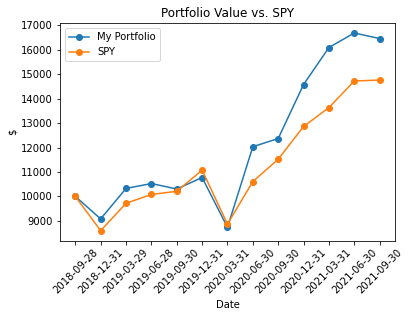

In [57]:
# plot of portfolio totals vs. SPY if buy and hold
plt.plot(SPY_test['Date'], portfolio_value['Total'], '-o', label = 'My Portfolio')
plt.plot(SPY_test['Date'], SPY_test['SPY_Total'], '-o', label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')
plt.xticks(rotation=45)
plt.show()

In [60]:
# invest 10000 evenly across top projected companies equally
portfolio_value_short = pd.DataFrame({})
running_total = init_investment
for i in range(len(dates)):
    amount_invested_per_stock = 500
    if i == 0:
        portfolio_value_short = portfolio_value_short.append(pd.DataFrame({dates[i]: [init_investment]}).T)
        continue
    tmp = portfolio[(portfolio['fiscalDateEnding'] == dates[i-1]) & (portfolio['BuyOrShort'] == 'Buy')]
    tmp2 = portfolio[(portfolio['fiscalDateEnding'] == dates[i-1]) & (portfolio['BuyOrShort'] != 'Buy')]
    tmp['returnPercentage'] = tmp['nextQuarterPrice'] / tmp['currentQuarterPrice']
    
    while ((len(tmp) * amount_invested_per_stock) > running_total) and amount_invested_per_stock >= 0:
        amount_invested_per_stock -= 50
    tmp['Value'] = tmp['returnPercentage'] * amount_invested_per_stock
    total = running_total - ((len(tmp) * amount_invested_per_stock) + (len(tmp2) * amount_invested_per_stock))
    total += tmp['Value'].sum()
    if len(tmp2) > 0:
        tmp2['returnPercentage'] = tmp2['currentQuarterPrice'] / tmp2['nextQuarterPrice']
        tmp2['Value'] = tmp2['returnPercentage'] * amount_invested_per_stock
        total += tmp2['Value'].sum()
    running_total = total
    portfolio_value_short = portfolio_value_short.append(pd.DataFrame({dates[i]: [running_total]}).T)
    
portfolio_value_short.columns = ['Total']
portfolio_value_short

/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_30423/570978297.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['returnPercentage'] = tmp['nextQuarterPrice'] / tmp['currentQuarterPrice']
/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_30423/570978297.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Value'] = tmp['returnPercentage'] * amount_invested_per_stock
/var/folders/qr/c62bp79j3c91gdkr6wydmq7h0000gn/T/ipykernel_30423/570978297.py:19: SettingWithCopyWarning: 
A v

,Total
2018-09-30,10000.000000
2018-12-31,9404.232776
2019-03-31,10471.127434
2019-06-30,10605.969437
2019-09-30,10260.018632
2019-12-31,10698.363640
2020-03-31,8954.601014
2020-06-30,12061.687598
2020-09-30,12456.370929
2020-12-31,14656.821019


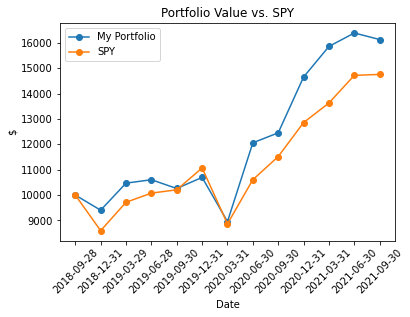

In [61]:
plt.plot(SPY_test['Date'], portfolio_value_short['Total'], '-o', label = 'My Portfolio')
plt.plot(SPY_test['Date'], SPY_test['SPY_Total'], '-o', label = 'SPY')
plt.legend()
plt.xlabel('Date')
plt.ylabel('$')
plt.title('Portfolio Value vs. SPY')
plt.xticks(rotation=45)
plt.show()